**Loading the Libraries & Data**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sb

import torch 
import torch.nn as nn
import torch.utils.data as td

# reading the data
jena_df = pd.read_csv("jena_climate_2009_2016.csv")

jena_df = jena_df.rename(columns={"Date Time": "DateTime", "p (mbar)": "Pressure", "T (degC)": "TempCelsius", "Tpot (K)": "TempKelvin", "Tdew (degC)": "TempDewCelsius",
                        "rh (%)": "RelativeHumidity", "VPmax (mbar)": "SatVapourPress", "VPact (mbar)": "VapourPressure", "VPdef (mbar)": "VapPressDeficit",
                        "sh (g/kg)": "SpecificHumidity", "H2OC (mmol/mol)": "WaterVapConc", "rho (g/m**3)": "AirDensity", "wv (m/s)": "WindSpeed",
                        "max. wv (m/s)": "MaxWindSpeed", "wd (deg)": "WindDirDegrees"})

__Data Preprocessing__

All these steps are explained in the data cleaning sheet and combined here in one cell for fast processing of the data.

In [ ]:
#taking only the hourly values
jena_df = jena_df[5::6]

#removing incorrect values
jena_df['WindSpeed'].replace(-9999, 0, inplace = True)
jena_df['MaxWindSpeed'].replace(-9999, 0, inplace = True)

#treating outliers
def out_treat(var):
    Q1 = np.quantile(var.dropna(), 0.25)
    Q3 = np.quantile(var.dropna(), 0.75)
    IQR = Q3-Q1
    LC = Q1 - (3 * IQR)
    UC = Q3 + (3 * IQR)
    var[var > UC] = UC
    var[var < LC] = LC
    return (var)
jena_df = jena_df[~jena_df.index.duplicated()]

jena_df.Pressure = out_treat(jena_df.Pressure)
jena_df.SatVapourPress = out_treat(jena_df.SatVapourPress)
jena_df.VapPressDeficit = out_treat(jena_df.VapPressDeficit)
jena_df.AirDensity = out_treat(jena_df.AirDensity)

#deriving the wind vector components
wv = jena_df.pop('WindSpeed')
max_wv = jena_df.pop('MaxWindSpeed')
# Convert to radians.
wd_rad = jena_df.pop('WindDirDegrees')*np.pi / 180
# Calculate the wind x and y components.
jena_df['Wx'] = wv*np.cos(wd_rad)
jena_df['Wy'] = wv*np.sin(wd_rad)
# Calculate the max wind x and y components.
jena_df['max Wx'] = max_wv*np.cos(wd_rad)
jena_df['max Wy'] = max_wv*np.sin(wd_rad)

#drop variables that have redundant data (multicollinearity)
jena_df.drop(['TempCelsius'],axis=1,inplace=True)
jena_df.drop(['VapourPressure'],axis=1,inplace=True)
jena_df.drop(['WaterVapConc'],axis=1,inplace=True)

#setting datetime as the index
jena_df.set_index('DateTime',inplace=True, drop=True)

#Seperating the independent and dependent data
data = jena_df
X = data.drop(columns=["TempKelvin"],axis=1)
y = data["TempKelvin"]

#Splitting the data for training and testing
x_train, x_test, y_train, y_test = train_test_split(X.values,y.values, test_size=0.2, shuffle=False)

#Scaling - Fit and Transform TRAIN data
min_max_scaler_x = MinMaxScaler()
x_train_sc = min_max_scaler_x.fit_transform(x_train)
x_test_sc = min_max_scaler_x.transform(x_test)

#Scaling - Fit and Transform TEST data
min_max_scaler_y = MinMaxScaler()    #we will use this scaler later to inverse transform predicted values
y_train_sc = min_max_scaler_y.fit_transform(y_train.reshape(-1,1))
y_test_sc = min_max_scaler_y.transform(y_test.reshape(-1,1))

#Converting back to Pandas dataframe
x_train = pd.DataFrame(x_train_sc, columns = X.columns)
x_test = pd.DataFrame(x_test_sc, columns = X.columns)
y_train = pd.DataFrame(y_train_sc, columns = ["TempKelvin"])
y_test = pd.DataFrame(y_test_sc, columns = ["TempKelvin"])

#merging the two datasets for both training and testing data
last_col = y_train.pop("TempKelvin")
x_train.insert(x_train.shape[1], "TempKelvin", last_col)
last_col = y_test.pop("TempKelvin")
x_test.insert(x_test.shape[1], "TempKelvin", last_col)

#concatenating train and test data
data = x_train.append(x_test)

__Creating Sequences & Transforming to tensors__

Step by Step Explanation:

1] Creating sequences of 168 lags (1 week of historical data)taken for all the data.

2] Splitting the data into train and test section as decided before.

3] Slicing the numpy arrays from both train and test data to create sequences train_x, train_y, test_x and test_y. (Keeping the mind here our train_y and test_y will be sequences of temperature over the next 24 hours.)

4] Transforming the numpy arrays into PyTorch tensors.

5] Joining input sequences tensors with output sequences tensors.

6] Defining batch size for train and test data and creating data loader files for both training and testing. 

In [ ]:
def split_data(inputDF, lookback, multiout):
    data_raw = inputDF.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size, :, :]
    y_train = data[lookback:train_set_size+lookback, :multiout, -1]
    
    x_test = data[train_set_size:-lookback, :, :]
    y_test = data[train_set_size+lookback:, :multiout, -1]
    
    return [x_train, y_train, x_test, y_test]


lookback = 168 # choose sequence length
multiout = 24 #series of temperatures that we will predict
x_train, y_train, x_test, y_test = split_data(data, lookback, multiout)

# converting numpy arrays to tensors
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

y_train = y_train.view(len(y_train), multiout)
y_test = y_test.view(len(y_test), multiout)

# creating dataloader objects
train_tensor = torch.utils.data.TensorDataset(x_train, y_train)
train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = np.math.ceil(len(x_train)/10), shuffle = False)

test_tensor = torch.utils.data.TensorDataset(x_test, y_test) 
test_loader = torch.utils.data.DataLoader(dataset = test_tensor, batch_size = len(x_test),shuffle = False)

Checking if GPU available, then using it!

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("SELECTED DEVICE: ", device)
torch.cuda.empty_cache()
host = torch.device('cpu')
print("HOST DEVICE: ", host)

SELECTED DEVICE:  cuda
HOST DEVICE:  cpu


#LSTM
Network Structure

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

__Defining the Model__

In [ ]:
input_dim = 12
hidden_dim = 64
output_dim = multiout
num_layers = 2
num_epochs = 40

**Running Model over Epochs**

In [ ]:
collect_MSE_sample = []

for i in range(30):
    from IPython.display import clear_output
    clear_output(wait=True)
    print("Iteration: ", i+1)
    
    model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, num_layers = num_layers, output_dim=output_dim)
    model.to(device)
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

    #defining a function for test data
    def validation(model):
        with torch.no_grad():
            for input, target in test_loader:       
                y_test_pred = model(input.to(device))
                test_loss = criterion(y_test_pred, target.to(device))
        return test_loss.item(), y_test_pred

    #training over the number of epochs
    import time #to measure the time taken by model to run
    training_losses = np.zeros(num_epochs)
    testing_losses = np.zeros(num_epochs)
    start_time = time.time()
    for t in range(num_epochs):
        for input, target in train_loader:       
            y_train_pred = model(input.to(device)) #predicted values of train data
            train_loss = criterion(y_train_pred, target.to(device)) #calculate train loss

            optimiser.zero_grad() #making the gradients zero
            train_loss.backward() #backpropogating through the network by changing weights
            optimiser.step()
            
        training_losses[t] = train_loss.item()
        testing_losses[t] = validation(model)[0]

        print("Epoch ", t, "Train MSE: ", train_loss.item(), "Test MSE: ", validation(model)[0])

    collect_MSE_sample.append(testing_losses[num_epochs-1])    
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))

Iteration:  30
Epoch  0 Train MSE:  0.029652245342731476 Test MSE:  0.053369686007499695
Epoch  1 Train MSE:  0.021788975223898888 Test MSE:  0.021084757521748543
Epoch  2 Train MSE:  0.013897228986024857 Test MSE:  0.019410880282521248
Epoch  3 Train MSE:  0.008198055438697338 Test MSE:  0.011454637162387371
Epoch  4 Train MSE:  0.006655916105955839 Test MSE:  0.008169889450073242
Epoch  5 Train MSE:  0.005688520614057779 Test MSE:  0.005790765397250652
Epoch  6 Train MSE:  0.004823657218366861 Test MSE:  0.005553819239139557
Epoch  7 Train MSE:  0.004701546858996153 Test MSE:  0.005668574012815952
Epoch  8 Train MSE:  0.004701432306319475 Test MSE:  0.005232235416769981
Epoch  9 Train MSE:  0.004502390045672655 Test MSE:  0.004827829077839851
Epoch  10 Train MSE:  0.004239307716488838 Test MSE:  0.004707731306552887
Epoch  11 Train MSE:  0.0041047921404242516 Test MSE:  0.004663456697016954
Epoch  12 Train MSE:  0.004040795378386974 Test MSE:  0.0048270877450704575
Epoch  13 Train MS

In [ ]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('#Points to Note:')
printmd(f"##1. Epochs Taken: {num_epochs}")
printmd(f"##2. Time Taken: {round(training_time)} seconds")
printmd(f"##3. testMSE_mean (30 samples): {round(np.mean(collect_MSE_sample), 6)}")
printmd(f"##3. testMSE_SD (30 samples): {round(np.std(collect_MSE_sample), 6)}")

#Points to Note:

##1. Epochs Taken: 40

##2. Time Taken: 108 seconds

##3. testMSE_mean (30 samples): 0.00246

##3. testMSE_SD (30 samples): 0.000133

**Transforming the scaled data to original**

In [ ]:
predict = pd.DataFrame(min_max_scaler_y.inverse_transform(validation(model)[1].to(host).detach().numpy()))
predict = predict.rename(columns={0: "+1 hour", 1: "+2 hour", 2: "+3 hour", 3: "+4 hour", 4: "+5 hour", 5: "+6 hour",
                                  6: "+7 hour", 7: "+8 hour", 8: "+9 hour", 9: "+10 hour", 10: "+11 hour",
                                  11: "+12 hour", 12: "+13 hour", 13: "+14 hour", 14: "+15 hour", 15: "+16 hour",
                                  16: "+17 hour", 17: "+18 hour", 18: "+19 hour", 19: "+20 hour", 20: "+21 hour",
                                  21: "+22 hour", 22: "+23 hour", 23: "+24 hour"})

original = pd.DataFrame(min_max_scaler_y.inverse_transform(y_test.detach().numpy()))
original = original.rename(columns={0: "+1 hour", 1: "+2 hour", 2: "+3 hour", 3: "+4 hour", 4: "+5 hour", 5: "+6 hour",
                                  6: "+7 hour", 7: "+8 hour", 8: "+9 hour", 9: "+10 hour", 10: "+11 hour",
                                  11: "+12 hour", 12: "+13 hour", 13: "+14 hour", 14: "+15 hour", 15: "+16 hour",
                                  16: "+17 hour", 17: "+18 hour", 18: "+19 hour", 19: "+20 hour", 20: "+21 hour",
                                  21: "+22 hour", 22: "+23 hour", 23: "+24 hour"})

#Original Values

In [ ]:
original.head(10)

,+1 hour,+2 hour,+3 hour,+4 hour,+5 hour,+6 hour,+7 hour,+8 hour,+9 hour,+10 hour,+11 hour,+12 hour,+13 hour,+14 hour,+15 hour,+16 hour,+17 hour,+18 hour,+19 hour,+20 hour,+21 hour,+22 hour,+23 hour,+24 hour
0,282.080017,284.230011,285.209991,284.819977,285.470001,285.829987,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980
1,284.230011,285.209991,284.819977,285.470001,285.829987,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999
2,285.209991,284.819977,285.470001,285.829987,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000
3,284.819977,285.470001,285.829987,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990
4,285.470001,285.829987,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990,283.880005
5,285.829987,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990,283.880005,284.200012
6,285.739990,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990,283.880005,284.200012,284.430023
7,286.980011,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990,283.880005,284.200012,284.430023,284.919983
8,283.940002,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990,283.880005,284.200012,284.430023,284.919983,285.369995
9,285.660004,285.290009,286.609985,286.929993,286.419983,285.559998,284.619995,284.119995,283.450012,283.039978,282.820007,282.679993,282.449982,281.790009,281.479980,281.529999,281.750000,282.489990,283.880005,284.200012,284.430023,284.919983,285.369995,285.679993


#Forecasted Values

In [ ]:
predict.head(10)

,+1 hour,+2 hour,+3 hour,+4 hour,+5 hour,+6 hour,+7 hour,+8 hour,+9 hour,+10 hour,+11 hour,+12 hour,+13 hour,+14 hour,+15 hour,+16 hour,+17 hour,+18 hour,+19 hour,+20 hour,+21 hour,+22 hour,+23 hour,+24 hour
0,281.873901,282.203949,282.358673,283.480347,283.695435,284.226562,285.395508,285.586243,286.237946,286.909363,287.507599,287.657257,287.328400,287.114746,286.855621,286.426971,285.934418,285.142639,284.335571,283.697357,283.206360,282.971344,282.535858,282.350555
1,282.144470,282.606262,282.885529,284.072723,284.354492,284.971405,286.087158,286.156342,286.760529,287.219025,287.712280,287.656281,287.189728,286.843384,286.417908,285.904053,285.317108,284.529724,283.758270,283.161316,282.761047,282.696838,282.429047,282.365997
2,283.658844,284.219666,284.547302,285.668640,285.991821,286.624237,287.489258,287.263641,287.698944,287.787384,288.154083,287.800659,287.205231,286.760925,286.121185,285.678680,284.971497,284.370850,283.720428,283.312592,283.030365,283.346649,283.333160,283.407715
3,284.770081,285.343201,285.693634,286.621826,286.909302,287.504486,288.070618,287.619537,287.812286,287.648438,287.758240,287.324005,286.571930,286.039978,285.340820,284.992645,284.427155,283.925110,283.545013,283.375824,283.255707,283.821747,283.972687,284.271606
4,284.741150,285.283905,285.638123,286.456635,286.626617,287.127472,287.551880,287.025055,287.050903,286.803101,286.775360,286.378876,285.527863,284.965485,284.348969,284.041046,283.625214,283.194336,282.989624,283.006104,282.990570,283.624939,283.851532,284.273041
5,285.583313,286.103241,286.382935,287.027710,287.127808,287.474213,287.648285,286.914459,286.737823,286.296265,286.223328,285.735443,284.913849,284.332336,283.773895,283.578918,283.180054,283.008636,282.929565,283.195953,283.239929,284.128418,284.507568,284.986420
6,286.113129,286.565582,286.745056,287.135925,287.120972,287.297821,287.204102,286.324677,285.923401,285.413025,285.195251,284.771179,283.972992,283.400452,282.990784,282.922668,282.759460,282.747925,282.905457,283.390656,283.541992,284.549255,284.990509,285.568970
7,285.885315,286.235504,286.309845,286.558563,286.343964,286.326508,286.118378,285.191986,284.665039,284.206360,283.946747,283.629974,282.904572,282.408234,282.213318,282.245605,282.311829,282.414398,282.728180,283.344330,283.595917,284.558258,284.983093,285.567596
8,286.216949,286.476654,286.373596,286.364777,285.968140,285.722687,285.307159,284.227844,283.544434,283.077271,282.772980,282.501953,281.977051,281.569336,281.619354,281.804810,282.137085,282.409271,282.945862,283.720673,284.070099,285.095123,285.500275,286.091492
9,284.259857,284.307617,284.128143,284.158051,283.561096,283.224792,283.022095,282.149078,281.641144,281.505127,281.276337,281.334839,280.832153,280.675385,280.981445,281.155029,281.732208,281.882050,282.438507,283.009552,283.458588,284.018707,284.188690,284.623901


**Plotting training and testing losses**

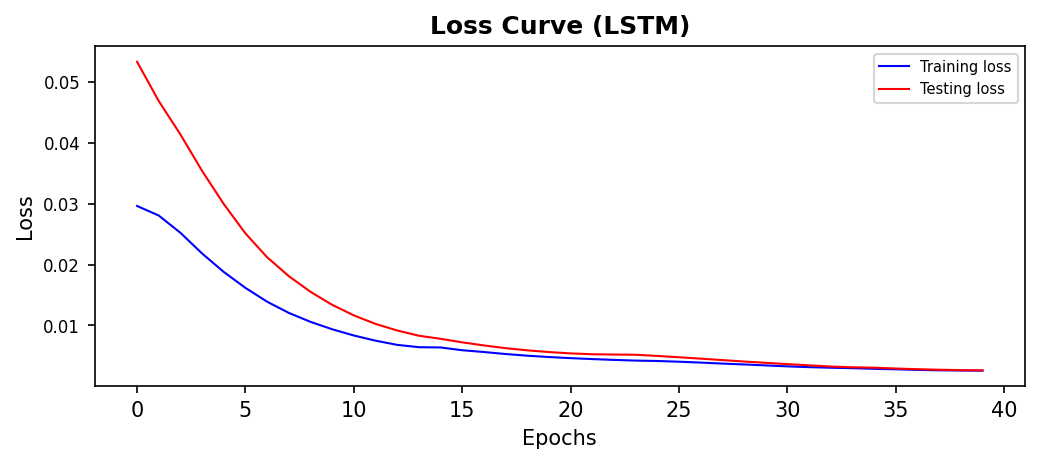

In [ ]:
def smooth_curve(points, factor=0.8): #this function will make our plots more smooth
	smoothed_points = []
	for point in points:
		if smoothed_points:
			previous = smoothed_points[-1]
			smoothed_points.append(previous*factor+point*(1-factor))
		else:
			smoothed_points.append(point)
	return smoothed_points


# plotting the training and validation loss
plt.figure(figsize=(8,3),dpi=150)
plt.plot(smooth_curve(training_losses), label='Training loss',color='blue',linewidth=1)
plt.plot(smooth_curve(testing_losses), label='Testing loss',color='red',linewidth=1)
plt.title('Loss Curve (LSTM)',fontweight='bold')
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.yticks(size=8)
plt.legend(prop={'size': 7})
plt.show()

**Plotting predicted values against actual values**

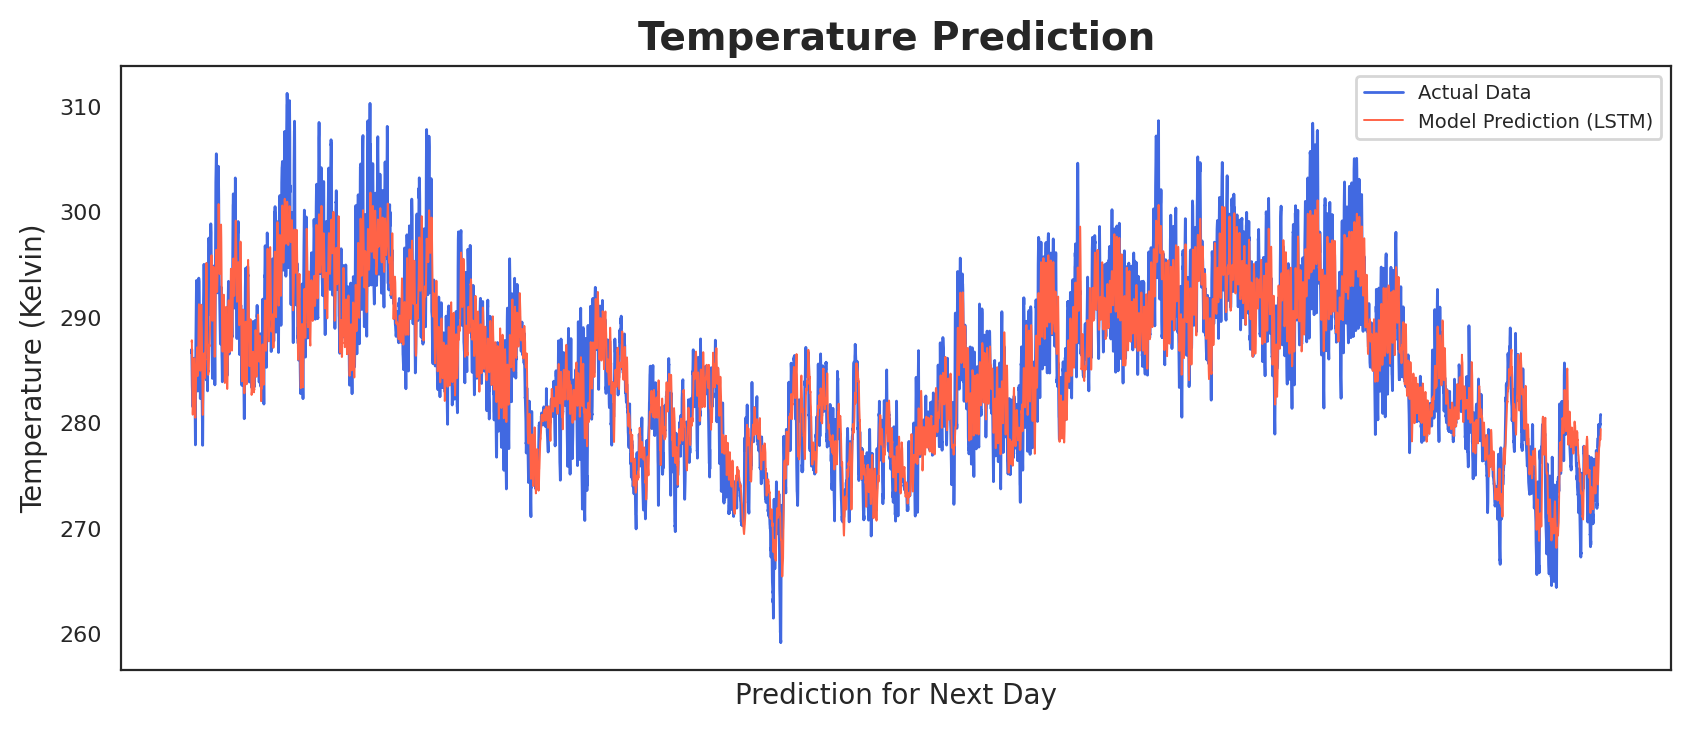

In [ ]:
plt.figure(figsize = (10,4), dpi=200)
sb.set_style("white")    

sb.lineplot(x = original.index, y = original["+12 hour"], label="Actual Data", color='royalblue',linewidth=1)
sb.lineplot(x = predict.index, y = predict["+12 hour"], label="Model Prediction (LSTM)", color='tomato',linewidth=0.7)
plt.title('Temperature Prediction', size = 14, fontweight='bold')
plt.xlabel("Prediction for Next Day", size = 10)
plt.ylabel("Temperature (Kelvin)", size = 10)
plt.xticks(ticks=[])
plt.yticks(size=8)
plt.legend(loc="upper right", prop={'size': 7})
plt.show()